# **Insurance Funds Classification - Supervised Learning**  
## **Team Members**:  
- **Itamar Melnik** (ID: 207312307)  
- **Tomer Sabag** (ID: 318814977)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ppscore as pps
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,roc_auc_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import warnings

## **Load and Preview the Data**

In [2]:
df = pd.read_csv('Insurance_data.csv', encoding= 'windows-1255' )

In [3]:
df.head()

,FUND_ID,FUND_NAME,PARENT_COMPANY_ID,PARENT_COMPANY_NAME,FUND_CLASSIFICATION,REPORT_PERIOD,TOTAL_ASSETS,AVG_ANNUAL_MANAGEMENT_FEE,AVG_DEPOSIT_FEE,MONTHLY_YIELD,...,AVG_ANNUAL_YIELD_TRAILING_5YRS,STANDARD_DEVIATION,ALPHA,SHARPE_RATIO,LIQUID_ASSETS_PERCENT,STOCK_MARKET_EXPOSURE,FOREIGN_EXPOSURE,FOREIGN_CURRENCY_EXPOSURE,PARENT_COMPANY_LEGAL_ID,CURRENT_DATE
0,1,"איי. די. איי. חברה לביטוח בע""מ מסלול אג""ח ממשלות",60,"ישיר -איי. די. איי. חברה לביטוח בע""מ",פוליסות שהונפקו החל משנת 2004,202401,88.87,1.01,NaN,0.27,...,2.06,1.87,0.36,0.24,89.9,1.37,7.46,11.20,513910703,12/29/2024 12:00:00 AM
1,1,"איי. די. איי. חברה לביטוח בע""מ מסלול אג""ח ממשלות",60,"ישיר -איי. די. איי. חברה לביטוח בע""מ",פוליסות שהונפקו החל משנת 2004,202402,88.05,1.01,NaN,0.15,...,2.01,1.87,0.24,0.18,90.0,1.62,7.41,11.18,513910703,12/29/2024 12:00:00 AM
2,1,"איי. די. איי. חברה לביטוח בע""מ מסלול אג""ח ממשלות",60,"ישיר -איי. די. איי. חברה לביטוח בע""מ",פוליסות שהונפקו החל משנת 2004,202403,87.89,1.01,NaN,0.66,...,2.07,1.91,0.36,0.21,89.6,1.70,7.90,11.80,513910703,12/29/2024 12:00:00 AM
3,1,"איי. די. איי. חברה לביטוח בע""מ מסלול אג""ח ממשלות",60,"ישיר -איי. די. איי. חברה לביטוח בע""מ",פוליסות שהונפקו החל משנת 2004,202404,86.32,1.01,NaN,-0.36,...,1.94,1.91,0.24,0.06,89.5,1.64,7.76,11.36,513910703,12/29/2024 12:00:00 AM
4,1,"איי. די. איי. חברה לביטוח בע""מ מסלול אג""ח ממשלות",60,"ישיר -איי. די. איי. חברה לביטוח בע""מ",פוליסות שהונפקו החל משנת 2004,202405,85.50,1.01,NaN,0.12,...,1.97,1.91,0.24,0.02,89.4,1.69,7.84,11.41,513910703,12/29/2024 12:00:00 AM


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   FUND_ID                         2140 non-null   int64  
 1   FUND_NAME                       2140 non-null   object 
 2   PARENT_COMPANY_ID               2140 non-null   int64  
 3   PARENT_COMPANY_NAME             2140 non-null   object 
 4   FUND_CLASSIFICATION             2140 non-null   object 
 5   REPORT_PERIOD                   2140 non-null   int64  
 6   TOTAL_ASSETS                    2140 non-null   float64
 7   AVG_ANNUAL_MANAGEMENT_FEE       1804 non-null   float64
 8   AVG_DEPOSIT_FEE                 1418 non-null   float64
 9   MONTHLY_YIELD                   2123 non-null   float64
 10  YEAR_TO_DATE_YIELD              1997 non-null   float64
 11  YIELD_TRAILING_3_YRS            1586 non-null   float64
 12  YIELD_TRAILING_5_YRS            14

## **Feature Relationship Analysis with PPS & Spearman Matrix**

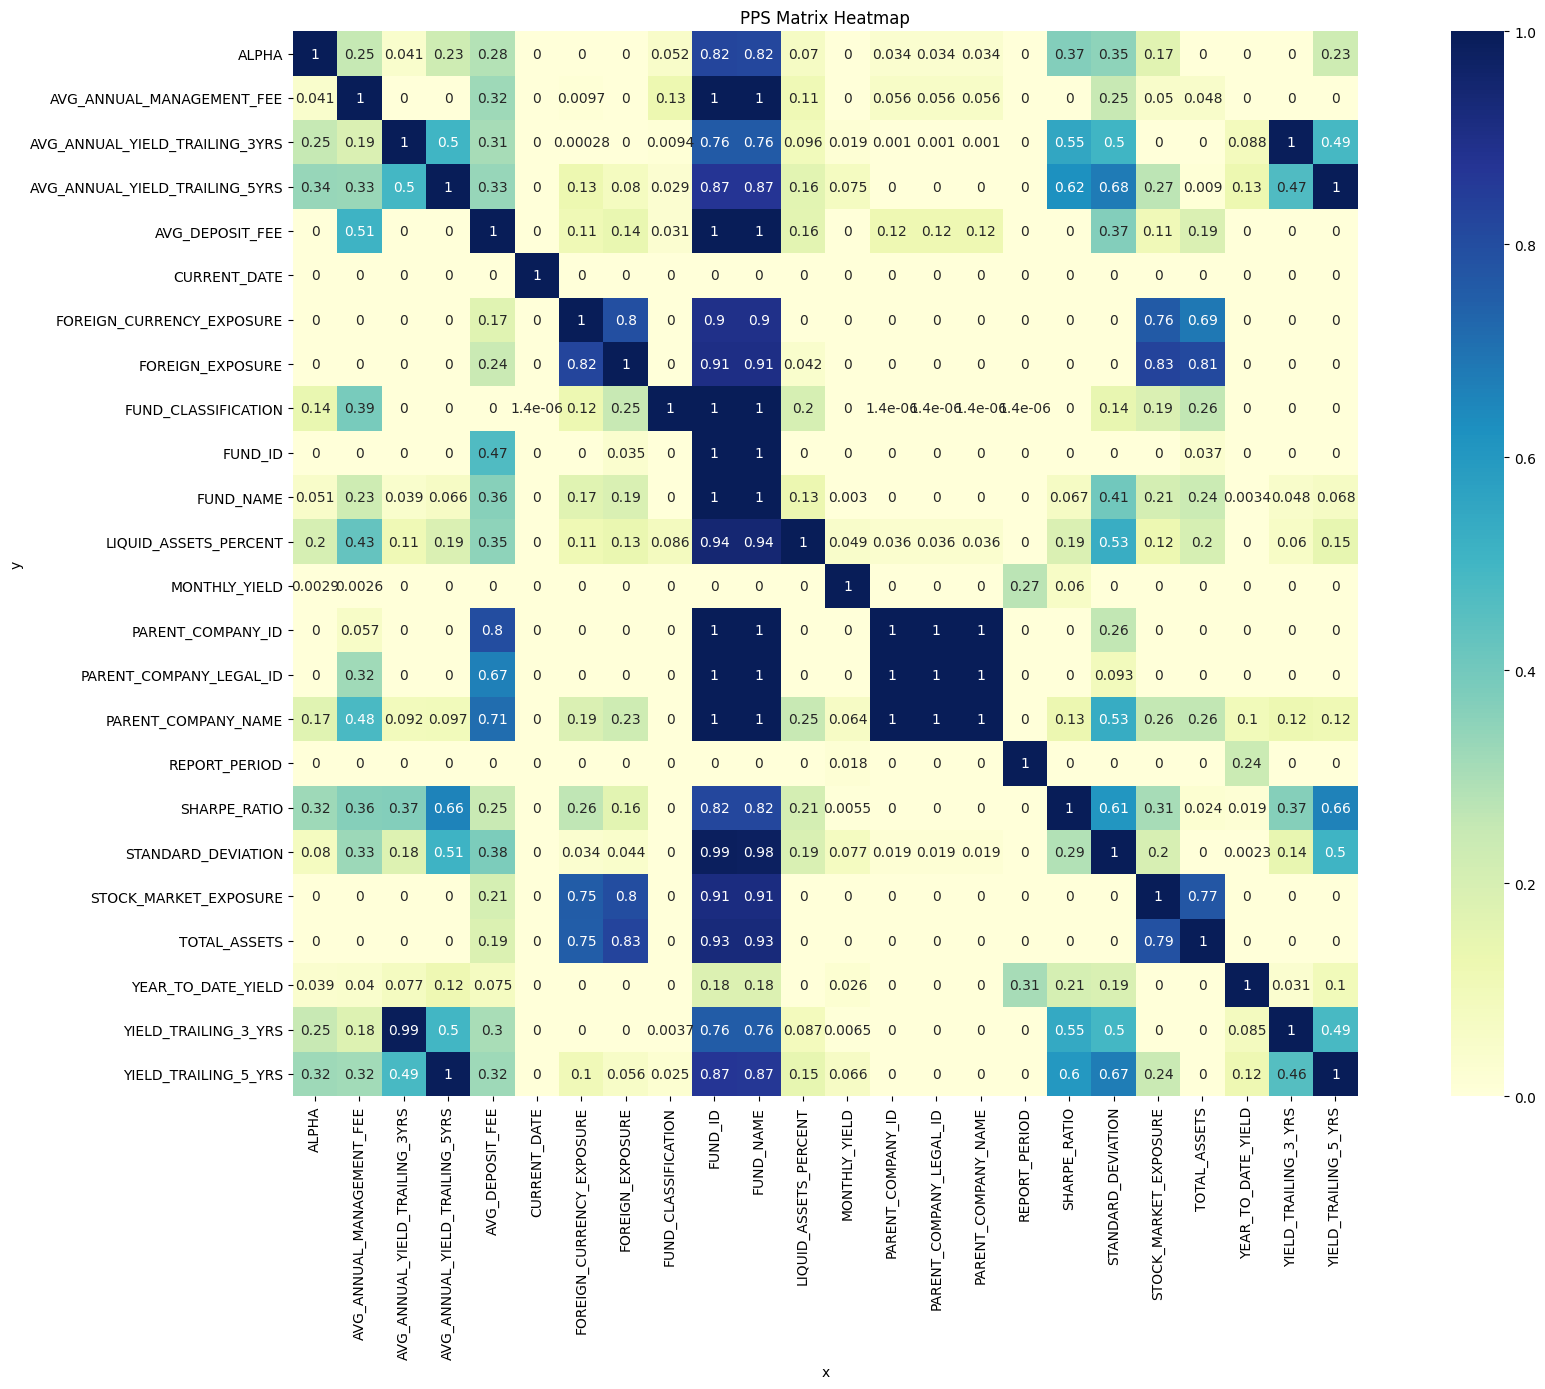

In [5]:
warnings.filterwarnings("ignore", category=UserWarning)

pps_matrix = pps.matrix(df)
pps_pivot = pps_matrix.pivot(index='x', columns='y', values='ppscore')

plt.figure(figsize=(20, 14))  
sns.heatmap(pps_pivot.transpose(), annot=True, cmap='YlGnBu', vmin=0, vmax=1, square=True)  


plt.title('PPS Matrix Heatmap')
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
plt.tight_layout()
plt.show()


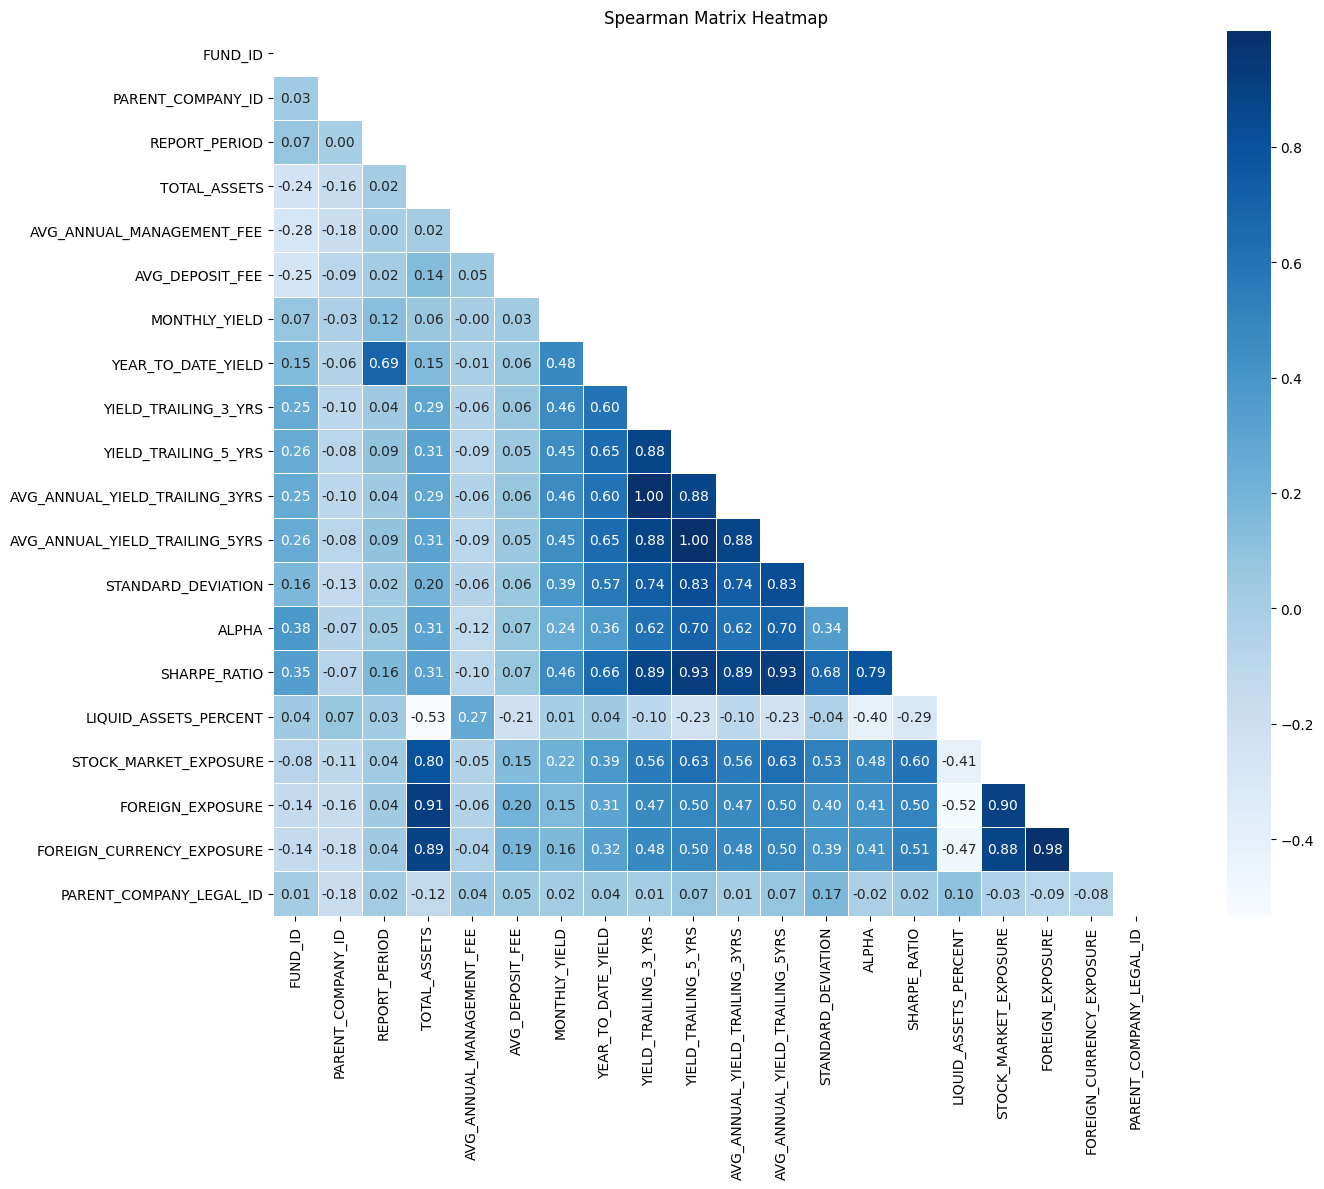

In [6]:
corr_data = df.select_dtypes(exclude=['object']).corr(method='spearman')
mask = np.triu(np.ones_like(corr_data, dtype=bool))

plt.figure(figsize=(16, 12)) 
sns.heatmap(corr_data, mask=mask, cmap='Blues', annot=True, fmt=".2f", linewidths=.5, square=True)  

plt.title('Spearman Matrix Heatmap')

plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

plt.tight_layout()
plt.show()

    ##  Column Removal

    1. **Dropped `CURRENT_DATE`**:
       - All values in this column are identical, providing no useful information for analysis.

    2. **Dropped `FUND_NAME`, `PARENT_COMPANY_ID`, `PARENT_COMPANY_NAME`, `FUND_CLASSIFICATION`, and `PARENT_COMPANY_LEGAL_ID`**:
       - These columns have perfect multicollinearity with the `FUND_ID` column, making them redundant.

    3. **Dropped `AVG_ANNUAL_YIELD_TRAILING_3YRS`**:
       - This column is perfectly explained by `YIELD_TRAILING_3_YRS` (100% correlation).

    4. **Dropped `AVG_ANNUAL_YIELD_TRAILING_5YRS`**:
       - This column is perfectly explained by `YIELD_TRAILING_5_YRS` (100% correlation).

    5. **Dropped `FOREIGN_EXPOSURE`**:
       - This column has a 98% correlation with `FOREIGN_CURRENCY_EXPOSURE`.

    6. **Dropped `FUND_ID`**:
       - Many columns have high correlation with `FUND_ID`. To avoid classification based on company identifiers rather than   financial data, we removed this column.
       - However, we are temporarily keeping the `FUND_ID` column to assist with the missing value imputation process and will remove it afterward..



In [7]:
df = df.drop(columns=['CURRENT_DATE','FUND_NAME','PARENT_COMPANY_ID','PARENT_COMPANY_NAME','FUND_CLASSIFICATION','PARENT_COMPANY_LEGAL_ID','AVG_ANNUAL_YIELD_TRAILING_3YRS','AVG_ANNUAL_YIELD_TRAILING_5YRS','FOREIGN_EXPOSURE'])

## **Fill Missing Values**

* We drop all rows where `ALPHA`, our target column, has missing values. 


In [8]:
df = df.dropna(subset=['ALPHA'])

## **Visualizing Missing Value Column ON Box Plots**


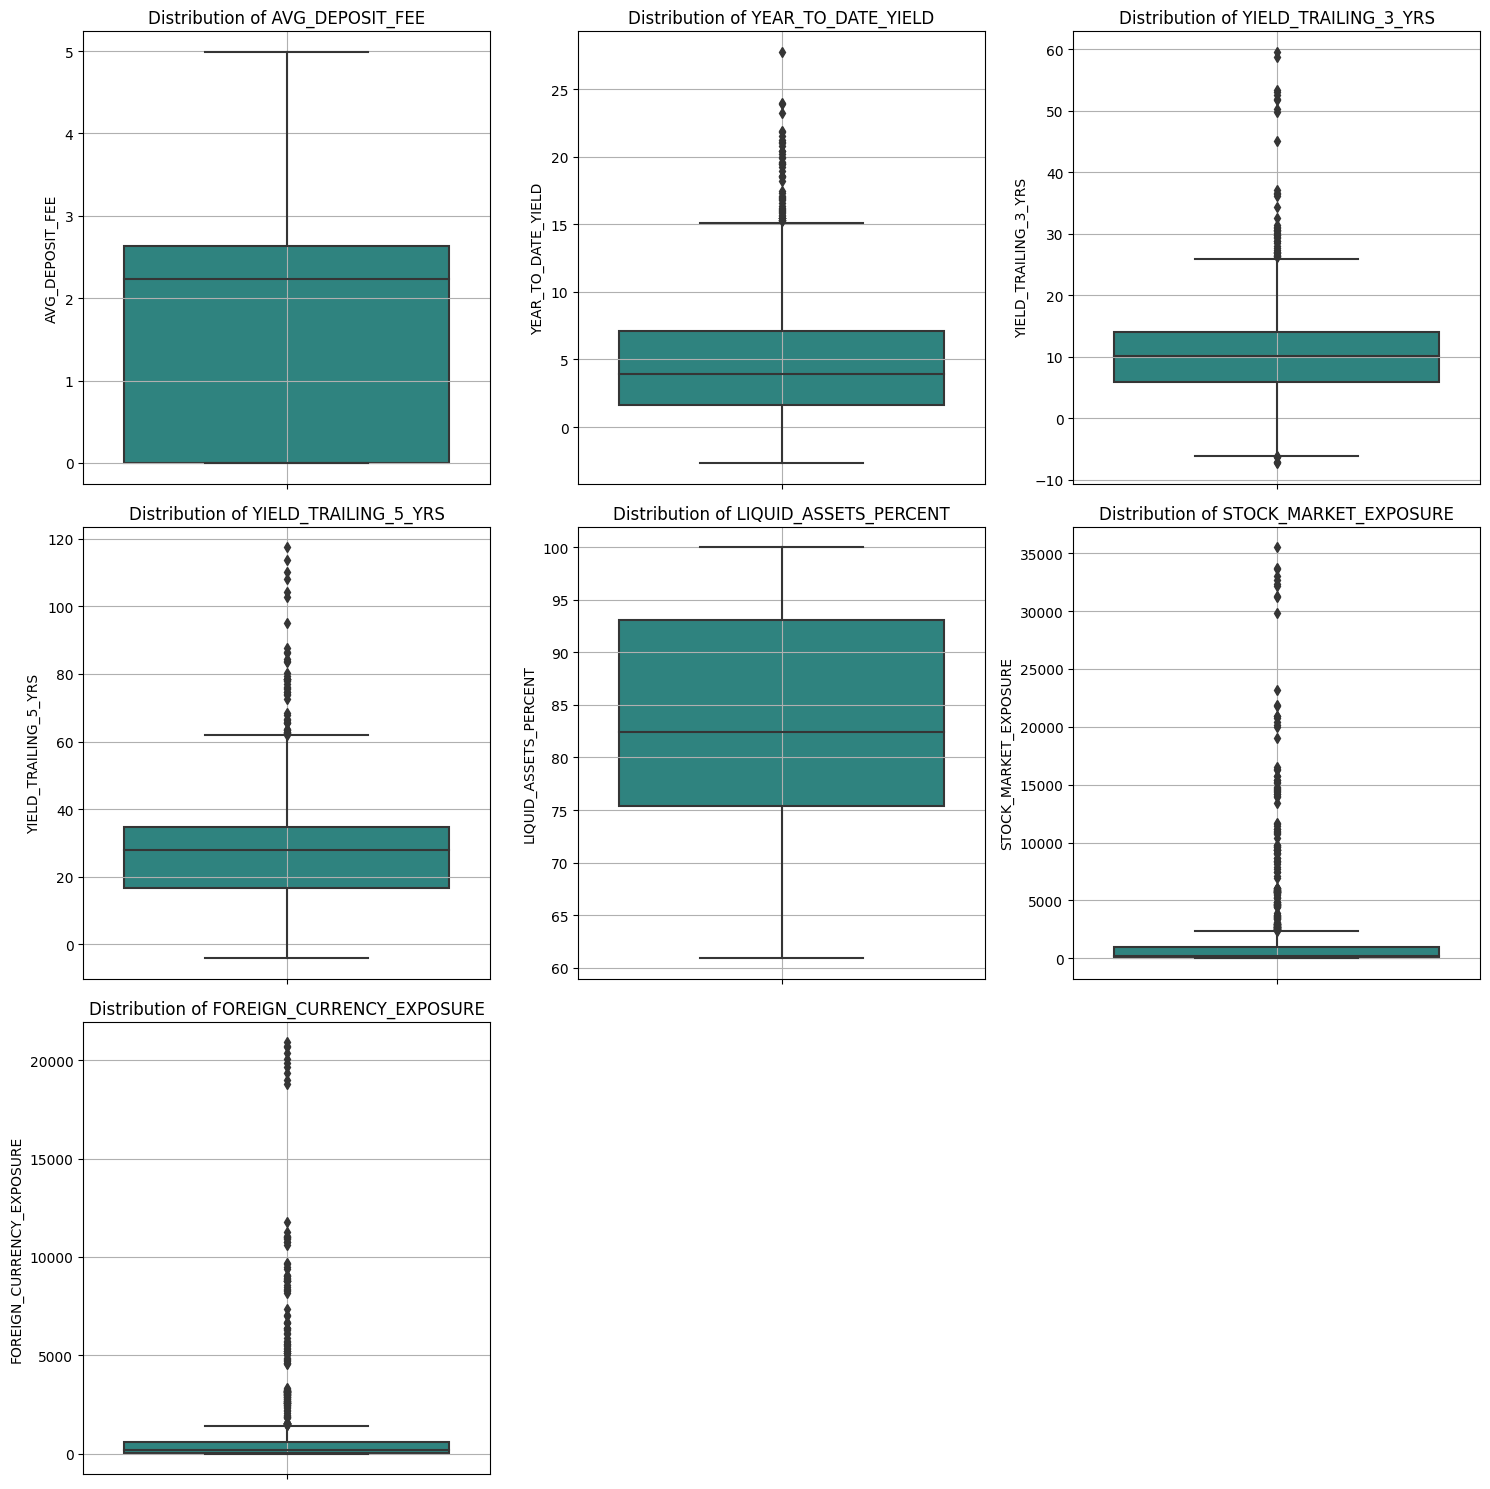

In [9]:
missing_columns = df.columns[df.isnull().any()]#GPT

num_cols = 3  
num_rows = math.ceil(len(missing_columns) / num_cols)  

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()  

for i, column in enumerate(missing_columns):
    sns.boxplot(data=df, y=column, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel('')  
    axes[i].set_ylabel(column)
    axes[i].grid(True)


for i in range(len(missing_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


### **Interpretation of Box Plots**:
- **Observation**: All columns, except `LIQUID_ASSETS_PERCENT`, have outliers or asymmetrical distributions. 
- **Imputation Decision**:
  - **Columns with outliers or  asymmetrical  distributions**: Filled with the median for robustness against outliers.
  - **`LIQUID_ASSETS_PERCENT`**: Filled with the mean.
  - **Group-Level Imputation**: Before applying global imputation, missing values are first filled using the mean of each company (`FUND_ID`), ensuring that company-specific trends are preserved

In [10]:
for col in df.drop(columns=['FUND_ID']):
    df[col] = df.groupby('FUND_ID')[col].transform(lambda x: x.fillna(x.mean()))
    
   
    
        
columns_to_fill_median = [
    'AVG_DEPOSIT_FEE', 'YEAR_TO_DATE_YIELD',
    'YIELD_TRAILING_3_YRS', 'YIELD_TRAILING_5_YRS',
    'STOCK_MARKET_EXPOSURE','FOREIGN_CURRENCY_EXPOSURE'
]

columns_to_fill_mean = ['LIQUID_ASSETS_PERCENT']


df[columns_to_fill_median] = df[columns_to_fill_median].fillna(df[columns_to_fill_median].median())

df[columns_to_fill_mean] = df[columns_to_fill_mean].fillna(df[columns_to_fill_mean].mean())

In [11]:
df = df.drop(columns=['FUND_ID']) 

 **Converting `REPORT_PERIOD` Column to Categorical**

In [12]:
df['REPORT_PERIOD'] = df['REPORT_PERIOD'].astype(object)

 **Converting Target Variable `ALPHA` to Binary**


In [13]:
df['ALPHA'] = np.where(df['ALPHA'] > 0, 1, 0)

**Splitting Features and Target**

In [14]:
X = df.drop(columns=['ALPHA'])
y = df['ALPHA']

## **Data Splitting and Preprocessing**

**Data Splitting**:
   - The dataset is split into training and testing sets with an 80-20 ratio using `train_test_split`.

**Feature Preprocessing**:
   - Numerical features are standardized using `StandardScaler` to ensure they have a mean of 0 and a standard deviation of 1.
   - Categorical features are one-hot encoded using `OneHotEncoder`, dropping the first category to avoid multicollinearity.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_features = X.select_dtypes(include=['object', 'category']).columns
numerical_features = X.select_dtypes(exclude=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

categorical_features_encoded = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_features_names = list(numerical_features) + list(categorical_features_encoded)

## **Hyperparameter Tuning for the 5 Models**

1. **Random Forest**
2. **Gradient Boosting**
3. **XGBoost**
4. **Support Vector Machine (SVM)**
5. **K-Nearest Neighbors (KNN)**


In [16]:
param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],  
    'max_depth': [5, 10, 20],                        
}

clf_rf = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(
    estimator=clf_rf,
    param_grid=param_grid_rf,
    cv=3,               
    scoring='accuracy', 
    verbose=1,       
    n_jobs=-1          
)

grid_search_rf.fit(X_train, y_train)
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters for Random Forest: {'max_depth': 20, 'n_estimators': 300}


In [17]:
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

clf_gb = GradientBoostingClassifier(random_state=42)
grid_search_gb = GridSearchCV(
    estimator=clf_gb,
    param_grid=param_grid_gb,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search_gb.fit(X_train, y_train)
print("Best Parameters for Gradient Boosting:", grid_search_gb.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


In [18]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

params = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='accuracy', cv=5, verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best parameters for XGB : ", grid_search.best_params_)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best parameters for XGB :  {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}


In [19]:
param_grid_svm = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.1, 1],
    'kernel': ['rbf', 'linear']
}

grid_search_svm = GridSearchCV(SVC(), param_grid_svm, scoring='roc_auc', cv=5, verbose=2, n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

print("Best parameters for SVM: ", grid_search_svm.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters for SVM:  {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [20]:
param_grid_knn = {
    'n_neighbors': list(range(3, 21, 2)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, scoring='roc_auc', cv=5, verbose=2, n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

print("Best parameters for KNN: ", grid_search_knn.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for KNN:  {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}


## **Training the 5 Models**

In [21]:
clf_rf = RandomForestClassifier( max_depth= 20,min_samples_split= 2, n_estimators= 300,random_state=42)

clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)

In [22]:
clf_gb = GradientBoostingClassifier(learning_rate= 0.1, max_depth= 7,
                                    n_estimators= 50, subsample= 0.8,random_state=42)

clf_gb.fit(X_train, y_train)
y_pred_gb = clf_gb.predict(X_test)

In [23]:
clf_xgb = xgb.XGBClassifier(eval_metric='mlogloss',colsample_bytree= 0.8, gamma= 0.2,                           
                            learning_rate= 0.1, max_depth= 3, n_estimators= 300, subsample= 0.8)

clf_xgb.fit(X_train, y_train)
y_pred_xgb = clf_xgb.predict(X_test)

In [24]:
clf_svm = SVC(kernel='rbf',C = 10, gamma= 0.1, random_state=42)
clf_svm.fit(X_train, y_train)

y_pred_svm = clf_svm.predict(X_test)

In [25]:
clf_knn = KNeighborsClassifier(metric = 'manhattan', n_neighbors = 8, weights = 'distance')
clf_knn.fit(X_train, y_train)

y_pred_knn = clf_knn.predict(X_test)

## **10 cross- validation for the 5 models**

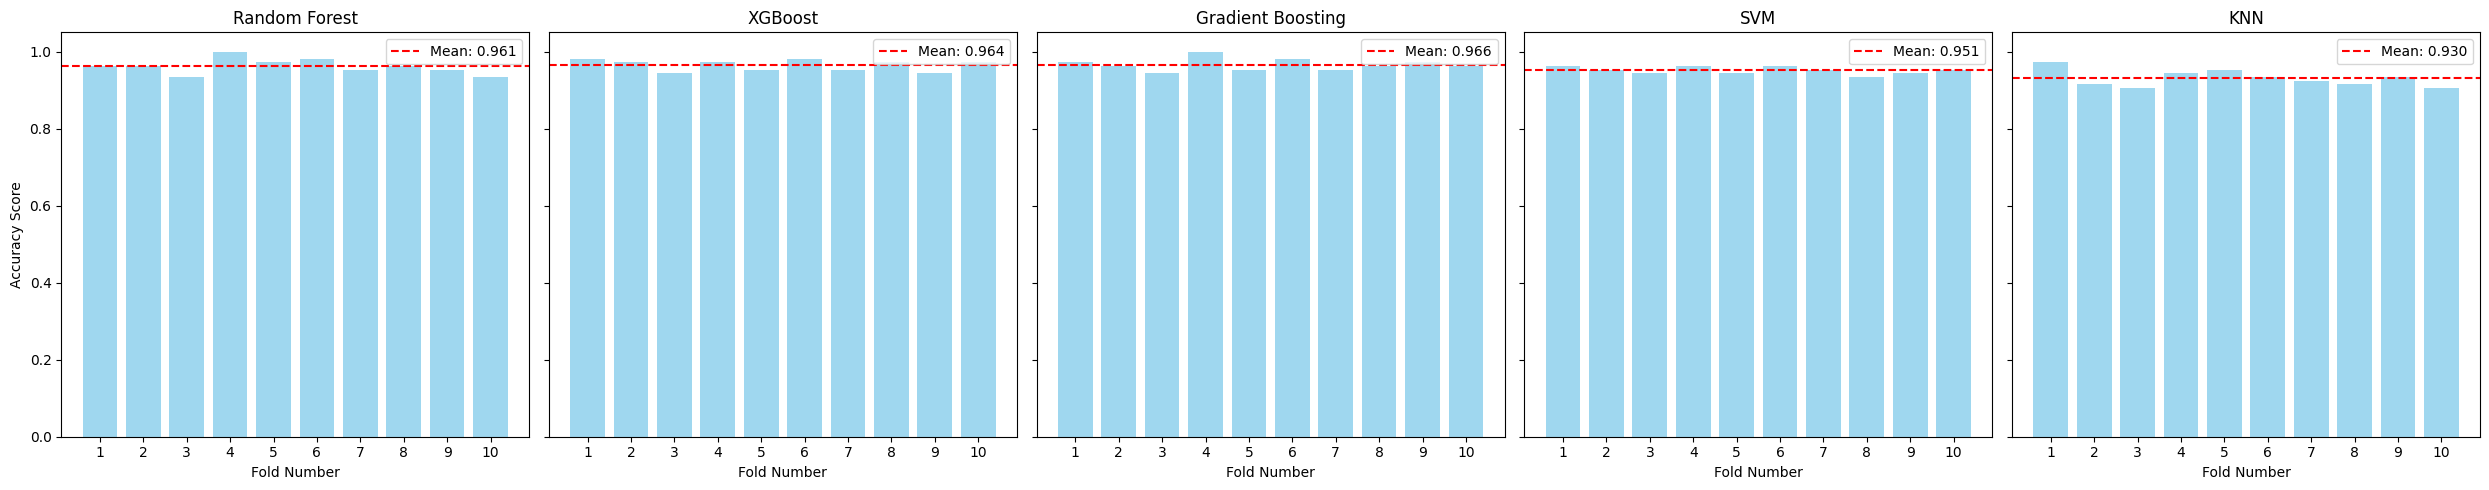

In [26]:
models = {#GPT
    'Random Forest': clf_rf,
    'XGBoost': clf_xgb,
    'Gradient Boosting': clf_gb,
    'SVM': clf_svm,
    'KNN': clf_knn
}

cv_scores_dict = {}

for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores_dict[model_name] = cv_scores

cv_results = pd.DataFrame(cv_scores_dict).T  
cv_results.columns = [f'Fold {i+1}' for i in range(cv_results.shape[1])]  
cv_results['Mean Accuracy'] = cv_results.mean(axis=1)  

fig, axes = plt.subplots(1, len(models), figsize=(25, 5), sharey=True)

for i, (model_name, cv_scores) in enumerate(cv_scores_dict.items()):
    ax = axes[i]
    ax.bar(range(1, len(cv_scores) + 1), cv_scores, color='skyblue', alpha=0.8)
    ax.axhline(y=cv_scores.mean(), color='red', linestyle='--', label=f'Mean: {cv_scores.mean():.3f}')
    ax.set_title(model_name)
    ax.set_xlabel('Fold Number')
    if i == 0:
        ax.set_ylabel('Accuracy Score')
    ax.set_xticks(range(1, len(cv_scores) + 1))
    ax.legend()

plt.tight_layout()
plt.show()

In [27]:
cv_results

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Fold 10,Mean Accuracy
Random Forest,0.962617,0.962617,0.934579,1.000000,0.971963,0.981132,0.952830,0.962264,0.952830,0.933962,0.961479
XGBoost,0.981308,0.971963,0.943925,0.971963,0.953271,0.981132,0.952830,0.971698,0.943396,0.971698,0.964318
Gradient Boosting,0.971963,0.962617,0.943925,1.000000,0.953271,0.981132,0.952830,0.962264,0.971698,0.962264,0.966196
SVM,0.962617,0.953271,0.943925,0.962617,0.943925,0.962264,0.952830,0.933962,0.943396,0.952830,0.951164
KNN,0.971963,0.915888,0.906542,0.943925,0.953271,0.933962,0.924528,0.915094,0.933962,0.905660,0.930480


**The cross-validation results show consistent accuracy across all 10 folds for each model, with minimal variance between folds. This indicates that the models generalize well and do not exhibit signs of overfitting.**

## Models Results

In [28]:
models_predictions = [#GPT
    ('Random Forest', y_pred_rf),
    ('Gradient Boosting', y_pred_gb),
    ('XGBoost', y_pred_xgb),
    ('SVM', y_pred_svm),
    ('KNN', y_pred_knn)
]

models_results = []

for model_name, y_pred in models_predictions:
    report = classification_report(y_test, y_pred, output_dict=True)
    models_results.append({
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': report['1']['precision'],  
        'Recall': report['1']['recall'],
        'F1-Score': report['1']['f1-score']
    })

results_df = pd.DataFrame(models_results)
results_df.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.966292,0.968254,0.983871,0.976000
2,XGBoost,0.955056,0.957895,0.978495,0.968085
1,Gradient Boosting,0.951311,0.957672,0.973118,0.965333
3,SVM,0.943820,0.952381,0.967742,0.960000
4,KNN,0.932584,0.937500,0.967742,0.952381


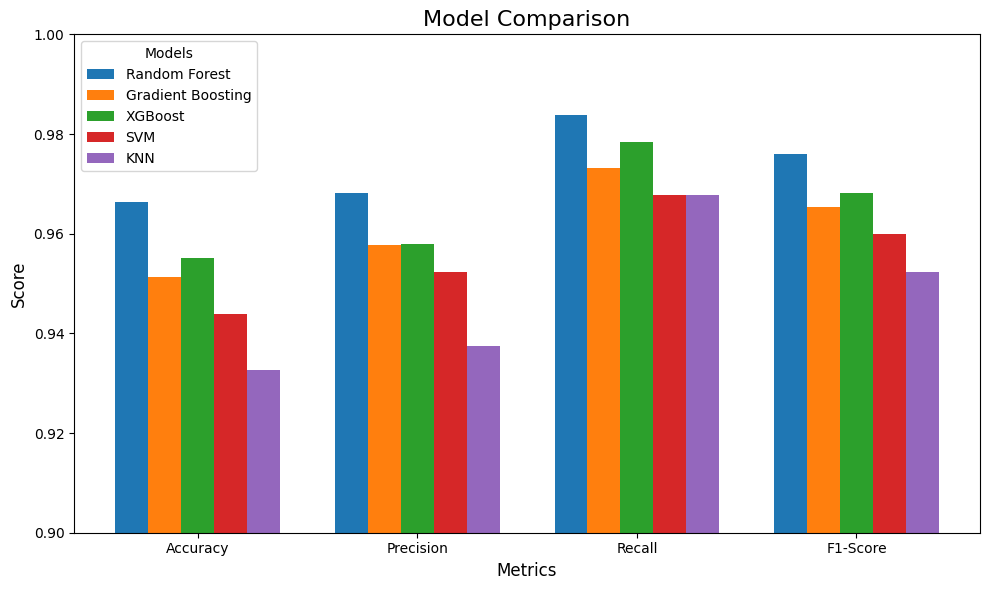

In [29]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']#GPT
models = results_df['Model']  
x = np.arange(len(metrics))  
width = 0.15  

fig, ax = plt.subplots(figsize=(10, 6))


for i, model in enumerate(models):
    ax.bar(
        x=x + i * width, 
        height=results_df.loc[i, metrics],  
        width=width,
        label=model
    )

ax.set_title('Model Comparison', fontsize=16)
ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_xticks(x + width * (len(models) - 1) / 2)  
ax.set_xticklabels(metrics, fontsize=10)  

ax.legend(title='Models', fontsize=10)  
ax.set_ylim(0.9, 1)  
plt.tight_layout()
plt.show()

### **Model Performance Interpretation**

The results indicate that **Random Forest** outperforms all other models across all metrics, achieving the highest accuracy (96.6%) and F1-score (97.6%). **XGBoost** (95.5% accuracy, 96.8% F1-score) and **Gradient Boosting** (95.1% accuracy, 96.5% F1-score) are close contenders, demonstrating strong and reliable performance as well. These results establish Random Forest as the most effective classifier for this task.


## **Feature Importance Analysis - Random Forest**

In [30]:
feature_importances = pd.DataFrame({
    'Feature': all_features_names,
    'Importance': clf_rf.feature_importances_
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
feature_importances

,Feature,Importance
6,YIELD_TRAILING_5_YRS,0.193891
8,SHARPE_RATIO,0.177706
9,LIQUID_ASSETS_PERCENT,0.121093
7,STANDARD_DEVIATION,0.115679
5,YIELD_TRAILING_3_YRS,0.093174
10,STOCK_MARKET_EXPOSURE,0.068670
0,TOTAL_ASSETS,0.049874
1,AVG_ANNUAL_MANAGEMENT_FEE,0.044453
11,FOREIGN_CURRENCY_EXPOSURE,0.043154
4,YEAR_TO_DATE_YIELD,0.028269


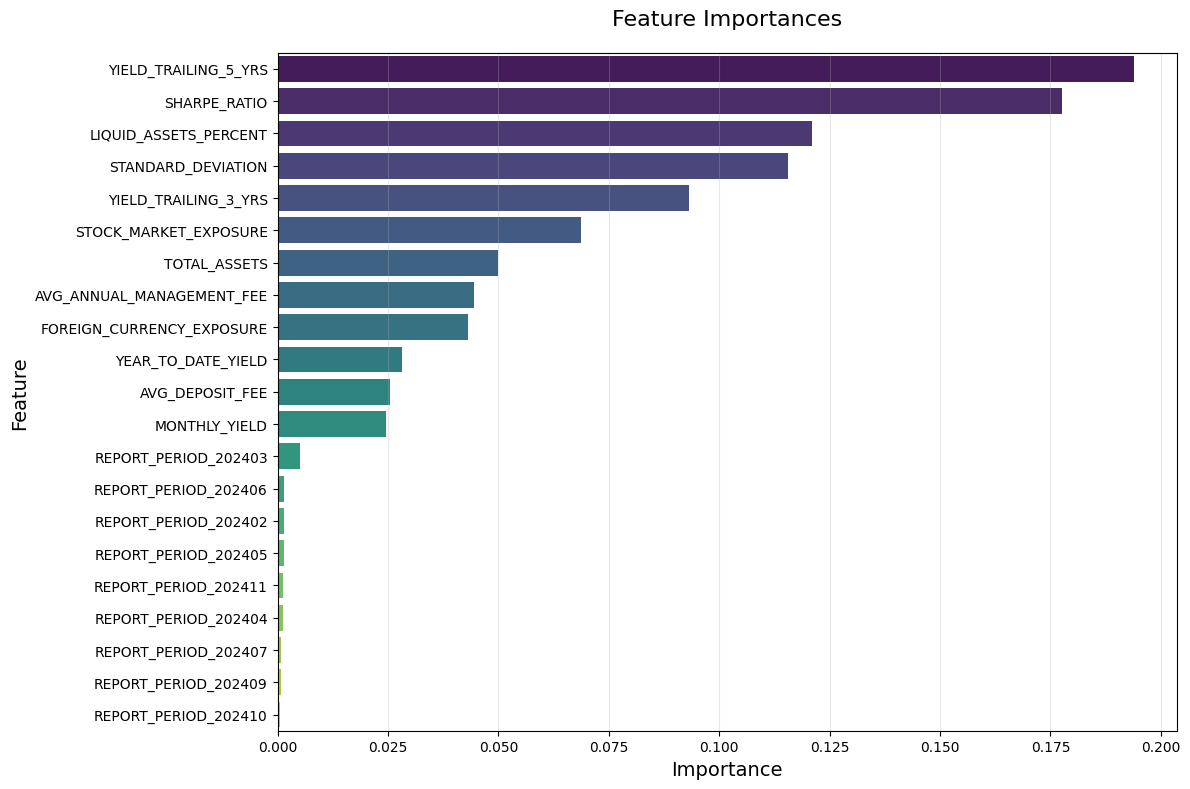

In [31]:
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_importances, 
    palette='viridis'
)


plt.title('Feature Importances', size=16, pad=20)
plt.xlabel('Importance', size=14)
plt.ylabel('Feature', size=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

plt.show()

### **Top 3 Most Important Features**

The top three features driving the Random Forest model are:  
1. **YIELD_TRAILING_5_YRS** (19.4%)  
2. **SHARPE_RATIO** (17.8%)  
3. **LIQUID_ASSETS_PERCENT** (12.1%)  



## End-to-End Pipeline

Performance Summary:
               Model  Accuracy  Precision    Recall  F1-Score
0      Random Forest  0.966292   0.968254  0.983871  0.976000
1  Gradient Boosting  0.951311   0.957672  0.973118  0.965333
2            XGBoost  0.951311   0.952880  0.978495  0.965517
3                SVM  0.943820   0.952381  0.967742  0.960000
4                KNN  0.932584   0.937500  0.967742  0.952381

Best Model: Random Forest


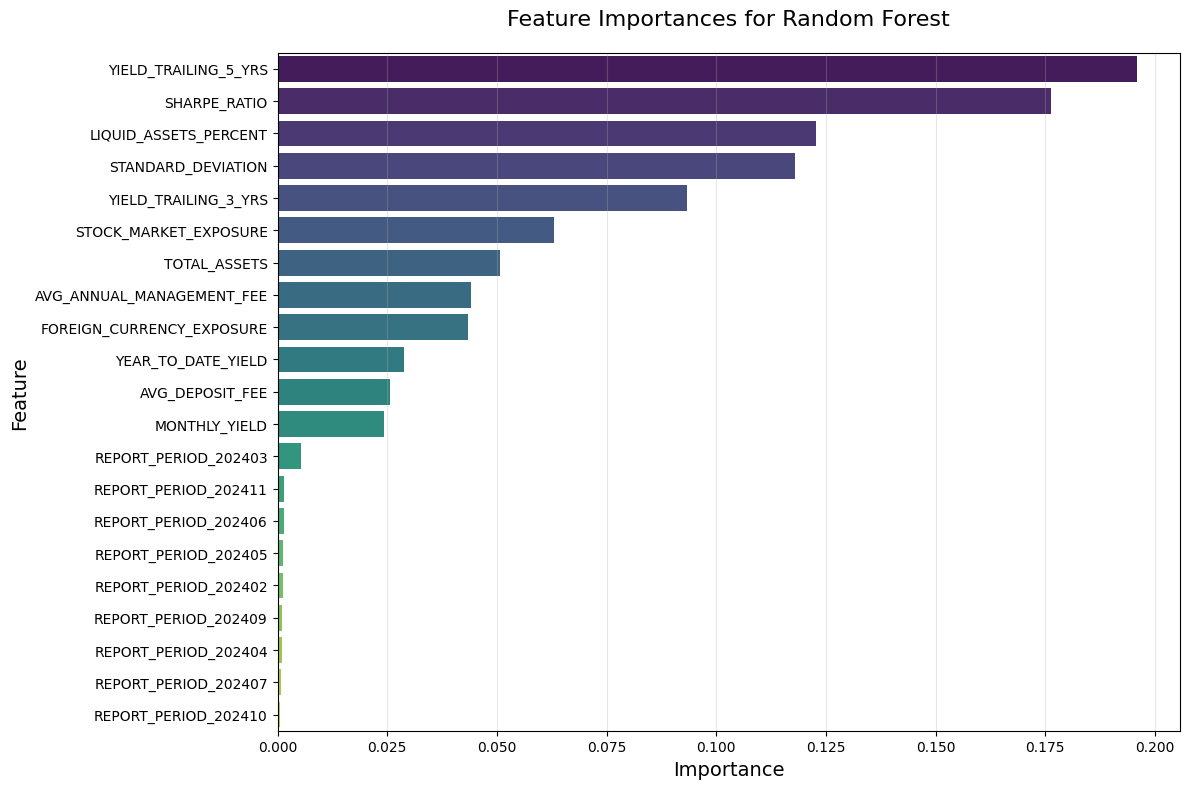

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# Load and preprocess data
def load_and_preprocess_data(file_path):#gpt
    df = pd.read_csv(file_path, encoding='windows-1255')

    # Drop multicollinearity columns
    df = df.drop(columns=[
        'CURRENT_DATE', 'FUND_NAME', 'PARENT_COMPANY_ID', 'PARENT_COMPANY_NAME',
        'FUND_CLASSIFICATION', 'PARENT_COMPANY_LEGAL_ID', 
        'AVG_ANNUAL_YIELD_TRAILING_3YRS', 'AVG_ANNUAL_YIELD_TRAILING_5YRS', 
        'FOREIGN_EXPOSURE'
    ])

    # Handle missing values
    df = df.dropna(subset=['ALPHA'])
    columns_to_fill_median = [
        'AVG_DEPOSIT_FEE', 'YEAR_TO_DATE_YIELD', 
        'YIELD_TRAILING_3_YRS', 'YIELD_TRAILING_5_YRS',
        'STOCK_MARKET_EXPOSURE', 'FOREIGN_CURRENCY_EXPOSURE'
    ]
    columns_to_fill_mean = ['LIQUID_ASSETS_PERCENT']
    df[columns_to_fill_median] = df[columns_to_fill_median].fillna(df[columns_to_fill_median].median())
    df[columns_to_fill_mean] = df[columns_to_fill_mean].fillna(df[columns_to_fill_mean].mean())
    df = df.drop(columns=['FUND_ID']) 
    
    df['REPORT_PERIOD'] = df['REPORT_PERIOD'].astype(object)
    # Encode target variable
    df['ALPHA'] = np.where(df['ALPHA'] > 0, 1, 0)
    
    return df

# Split the data into training and test sets
def split_data(df):
    X = df.drop(columns=['ALPHA'])
    y = df['ALPHA']
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess data
def preprocess_data(X_train, X_test):
    categorical_features = X_train.select_dtypes(include=['object', 'category']).columns
    numerical_features = X_train.select_dtypes(exclude=['object', 'category']).columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
        ])

    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    categorical_features_encoded = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features) 
    all_features_names = list(numerical_features) + list(categorical_features_encoded)
    
    return X_train, X_test, all_features_names

# Define models
def define_models():
    return {
        'Random Forest': RandomForestClassifier(
             max_depth=20, n_estimators=300, random_state=42
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.8, random_state=42
        ),
        'XGBoost': xgb.XGBClassifier(
            eval_metric='mlogloss', colsample_bytree=0.8, gamma=0.2, 
            learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.8
        ),
        'SVM': SVC(kernel='rbf', C=10, gamma=0.1, random_state=42),
        'KNN': KNeighborsClassifier(metric='manhattan', n_neighbors=8, weights='distance')
    }

# Train and evaluate models
def train_and_evaluate_models(models, X_train, X_test, y_train, y_test, all_features_names):
    models_results = []
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Evaluate performance
        report = classification_report(y_test, y_pred, output_dict=True)
        accuracy = accuracy_score(y_test, y_pred)
        models_results.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': report['1']['precision'],
            'Recall': report['1']['recall'],
            'F1-Score': report['1']['f1-score']
        })

    # Summarize results
    results_df = pd.DataFrame(models_results)
    print("Performance Summary:")
    print(results_df)

    # Find the best model
    best_model_name = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']
    best_model = models[best_model_name]
    print(f"\nBest Model: {best_model_name}")
    
    # Plot feature importances if supported
    if hasattr(best_model, 'feature_importances_'):
        feature_importances = pd.DataFrame({
            'Feature': all_features_names,
            'Importance': best_model.feature_importances_
        }).sort_values(by='Importance', ascending=False)

        plt.figure(figsize=(12, 8))
        sns.barplot(
            x='Importance', 
            y='Feature', 
            data=feature_importances, 
            palette='viridis'
        )
        plt.title(f'Feature Importances for {best_model_name}', size=16, pad=20)
        plt.xlabel('Importance', size=14)
        plt.ylabel('Feature', size=14)
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()

    return results_df, best_model_name

# Run the entire pipeline
def run_pipeline(file_path):
    df = load_and_preprocess_data(file_path)
    X_train, X_test, y_train, y_test = split_data(df)
    X_train, X_test, all_features_names = preprocess_data(X_train, X_test)
    models = define_models()
    results_df, best_model_name = train_and_evaluate_models(models, X_train, X_test, y_train, y_test, all_features_names)
    return results_df, best_model_name

# Execute the pipeline
results, best_model = run_pipeline('Insurance_data.csv')